In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree


import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

import GenerateEndpoints as ge
import matplotlib.pyplot as plt

import copy
import Guided_Midpoint_Buttress as gmp

device name /device:GPU:0


In [2]:
def add_loops(end_points, neighbors=10, length_mod=1, dist_cut=6, phiQueryNum=10, randMult=10, maxPhi_cut=20,
              uniquePhi=True, verbose=False, maxReruns = 4):
    """Chains first_helix, first_loop, second helix and the iteratively loop_then_helix to add all loops to endpoints."""
    
    epIn = end_points.copy()
    size = int(len(epIn)/2) #number of helixes represented by helical endpoints
    
   
    bL, iL, epGuide = le.first_helix(epIn,length_mod=length_mod)
    if verbose:
        print(f'first helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    bL, iL, epGuide, epTrue, phiList, loopFeature, xform_True = le.first_loop(bL, iL, epGuide, 
                                                                neighbors=neighbors, phiQueryNum=phiQueryNum,
                                                                           randMult=randMult, distCut=dist_cut)
    if verbose:
        print(f'first loop: #{iL.shape[0]}')
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    hnum=1
    bL, iL, epGuide, epTrue, phiList = le.second_helix(bL, iL, epGuide, epTrue, phiList, hnum, loopFeature, 
                                                   xform_True, length_mod=length_mod, distCut=dist_cut)
    if verbose:
        print(f'second helix: #{iL.shape[0]}')
    
    if iL.shape[0] == 0:
        if verbose:
            print('fail')
        return bL, iL, phiList, iL, iL, False
    
    repeatNumber = 0 
    hnum = 0
    
    bL_s = []
    iL_s = []
    epGuide_s = []
    epTrue_s = []
    phiList_s =  []
    for x in range(0,(size-1)):
        bL_s.append([])
        iL_s.append([])
        epGuide_s.append([])
        epTrue_s.append([])
        phiList_s.append([])
        
    
    while hnum<(size-2):
        hnum += 1
        if verbose:
            print('hnum',hnum)
        bL, iL, epGuide, epTrue, phiList = le.next_loop_helix(bL, iL, epGuide, epTrue, phiList, hnum, 
                neighbors=neighbors, phiQueryNum=phiQueryNum, randMult=randMult, distCut=dist_cut,length_mod=length_mod)
       
        bL_s[hnum] = copy.deepcopy(bL)
        iL_s[hnum] = iL.copy()
        epGuide_s[hnum] = epGuide.copy()
        epTrue_s[hnum] = epTrue.copy()
        phiList_s[hnum] = phiList.copy()
        
        if iL.shape[0] == 0:
            
            hnum = hnum - 2
            
            bL = bL_s[hnum] 
            iL = iL_s[hnum] 
            epGuide = epGuide_s[hnum] 
            epTrue = epTrue_s[hnum] 
            phiList = phiList_s[hnum] 
            
            neighbors += 5
            maxPhi_cut += 100
            
            repeatNumber += 1
            print('rn:', repeatNumber)
                
            if repeatNumber == maxReruns:
                if verbose:
                    print('fail2')
                return bL, iL, phiList, iL, iL, False
            
        if iL.shape[0] > maxPhi_cut:
            indexer = le.random_reduce(bL,num_to_keep = maxPhi_cut)
            bL = bL[indexer]
            iL = iL[indexer] 
            epGuide = epGuide[indexer]
            epTrue =  epTrue[indexer]
            phiList = phiList[indexer]
            if verbose:
                print(f'{hnum+2} helix: reduced to #{maxPhi_cut}')
        if verbose:
            print(f'{hnum+2} helix: #{iL.shape[0]}')
            
         
    #only return proteins with a unique set of loops queried from different phi bins
    if uniquePhi:
        phiList, u_indices = np.unique(phiList,axis=0,return_index=True)
        epGuide = epGuide[u_indices]
        epTrue = epTrue[u_indices]
        iL = iL[u_indices]
        bL = bL[u_indices]
    
    return bL, iL, phiList, epGuide, epTrue, True

In [3]:
#generate guide points

def generate_parabola(start, stop, h=[20,20,20], k=[20,30,40], num_points = 100):
    #create a set of parabolas past through ([0,0]) start of helices to vertex ([[10,20],[10,30],[10,40]])
    # (x-h)^2 = -4(a)(y-k)
    # Solve for 'a' at x=0, y=0
    # (0-h)^2 = -4(a)(0-k)
    #      a  =  h^2/4k
    h = np.array(h).reshape((-1,1))
    k = np.array(k).reshape((-1,1))
    a = np.square(h)/(4*k)
    
    #trace x from 0 to 10
    # -4ay +4ak = (x-h)^2
    # -4ay = (x-h)^2 - 4ak
    #    y = ( (x-h)^2 - 4ak  ) / (-4a)
    #    y = (4ak - (x-h)^2)
    x = np.repeat(np.expand_dims(np.linspace(start,stop,num=100), axis=0), h.shape[0],axis=0)
    z = np.divide(4*a*k -np.square(x-h), (4*a))
   
    x=np.expand_dims(x,axis=2)
    z=np.expand_dims(z,axis=2)
    y = np.zeros_like(x)
    gen_para =  np.concatenate((x,y,z),axis = 2)
    
    return gen_para
    
#rotate parabola around the x axis
# angleDeg = 90
# gpi = 1
# xfr=nu.xform_from_axis_angle_deg([1,0,0],angleDeg)
# gp = np.hstack((g_para[gpi],np.ones_like(g_para[gpi,:,gpi].reshape((-1,1)))  ))
# gp_z=nu.xform_npose(xfr,gp)[:,:3]
# gp_z.shape

# plt.scatter(gp_z[:,0], gp_z[:,2], alpha=0.5)
# plt.axis('equal')
# plt.show()


def generate_pos_circle(start, stop, h=30, k=0, r=30, num_points= 100):
    """Generate guide points originating a the origin for a circle, positive values only. """
    #(x-h)^2 + (y-k)^2 = r^(2)
    # y = sqrt(r^2-(x-h^2))+k
    x = np.linspace(start,stop,num=num_points)
    z = np.sqrt(np.square(r)-np.square(x-h))+k
    y = np.zeros_like(x)
    return np.concatenate((x.reshape((-1,1)),y.reshape((-1,1)),z.reshape((-1,1))),axis=1)

def add_xline(inputP, line_length, num=60):
    line = np.zeros((num,3))
    line[:,0] = np.linspace(0, line_length, num=num)
    cline = inputP[-1]+line
    ci_line = np.concatenate((inputP,cline),axis=0)
    
    return ci_line

circ_gp = generate_pos_circle(0,30,h=30,k=0,r=30, num_points= 100)
ci_line = add_xline(circ_gp[:-1], 10, num=30)

In [4]:
# nump = 100
# ini = np.zeros((nump,3))

# ini[:20,2] = np.linspace(0,20,num=20)
# ini[20:,2] = 20
# ini[20:,1] = np.linspace(0,40,num=80)

In [29]:
start_hel = gmp.get_reference_input(batch=50)

In [30]:
# %%time
# out_ep = gmp.build_protein_on_guide_clash(start_hel, circ_gp, batch=10, 
#                                  next_mp_dist=9, mp_deviation_limit = 5,maxOut=1000,maxClash_num=5)

In [31]:
%%time
# ci_line = add_xline(circ_gp, 20, num=60)
out_ep = gmp.build_protein_on_guide_clash(start_hel, ci_line, batch=200, 
                                 next_mp_dist=10, mp_deviation_limit = 5,maxOut=2000, maxClash_num=3)


# out_ep = gmp.build_protein_on_guide(start_hel, ci_line, batch=50, 
#                                  next_mp_dist=10, mp_deviation_limit = 5,maxOut=1000)

max next indices 6
(50, 8, 3)
Input Size: 10000
backprop time :  3.4611117839813232
Passing Filters: 1259 
MDS time:  30.030803680419922
clash time:  0.6573450565338135
final pass filter 947
max next indices 25
(947, 8, 3)
Input Size: 189400
backprop time :  14.388966798782349
Passing Filters: 2000 
MDS time:  45.295198917388916
clash time:  1.0050263404846191
final pass filter 571
max next indices 58
(571, 8, 3)
Input Size: 114200
backprop time :  10.108299970626831
Passing Filters: 2000 
MDS time:  45.021082162857056
clash time:  0.9189817905426025
final pass filter 167
max next indices 95
(167, 8, 3)
Input Size: 33400
backprop time :  5.075440883636475
Passing Filters: 1525 
MDS time:  33.112364053726196
clash time:  0.8465487957000732
final pass filter 204
max next indices 116
(204, 8, 3)
Input Size: 40800
backprop time :  5.38405442237854
Passing Filters: 2000 
MDS time:  45.573134899139404
clash time:  0.6207783222198486
final pass filter 94
max next indices 124
(51, 8, 3)
Input 

In [32]:
sumL = 0

for i,x in enumerate(out_ep):
    sumL += len(x)
    print(i, len(x))
print('total',sumL)

0 43
total 43


In [58]:
out_ep[0].shape

(43, 24, 3)

In [50]:
gmp.vp(out_ep[0],ci_line,name='ci_line4',max_out=1000)

In [12]:
gmp.vp(out_ep[1],ci_line,name='testzzz',max_out=1000)

In [43]:
hf.HelicalProtein.makePointPDB(circ_gp,'ci_line.pdb',outDirec='output/')

1

(array([ 2.,  1., 16.,  1.,  0.,  7.,  8.,  5.,  2.,  1.]),
 array([ 2. ,  2.8,  3.6,  4.4,  5.2,  6. ,  6.8,  7.6,  8.4,  9.2, 10. ]),
 <BarContainer object of 10 artists>)

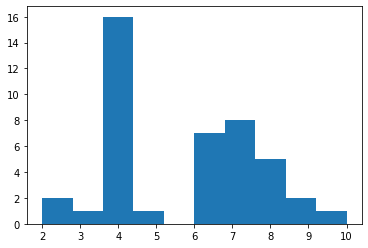

In [36]:
import LoopEndpoints as le
#code to 
epr = ge.EP_Recon(out_ep[0])
eprn = epr.to_npose()
hll = np.array(epr.helixLength_list)
hll.shape
clash_num = []
for x in range(len(eprn)):
    clash_num.append(le.whole_prot_clash_check(eprn[x],hll[x]))
plt.hist(clash_num)   

In [37]:
clash_num[0]

4

In [38]:
cn_bon = np.nonzero(np.array(clash_num)<10)[0]

In [39]:
cn_bon

array([ 0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42], dtype=int64)

In [25]:
import LoopEndpoints as le
end_points = out_ep[0][0]
length_mod=1
dist_cut=2
phiQueryNum=10
neighbors = 10
randMult=10
maxPhi_cut=20
verbose= True

In [ ]:
end_points.shape

In [42]:

timeList = []
bL_List = []
sucList = []

for x in range(out_ep[0].shape[0]):
    s = time.time()
    end_points = out_ep[0][x]
    bL, iL, phiList, epGuide, epTrue, suc= add_loops(end_points, neighbors=200, length_mod=3, dist_cut=3, phiQueryNum=10, randMult=0, maxPhi_cut=1000,
                  uniquePhi=True, verbose=False, maxReruns=1)
    print(len(bL))
    
    bL_List.append(bL)
    sucList.append(suc)
    
    print(time.time()-s)
    timeList.append(time.time()-s)
    
    print()
    
    

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
rn: 1
5
10.01742434501648

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
27
17.64916729927063

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
23
38.70766758918762

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
rn: 1
952
28.209567070007324

hnum 1
rn: 1
0
1.7138888835906982

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
50
37.65041375160217

hnum 1
rn: 1
0
1.5404753684997559

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
71
40.133684396743774

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
rn: 1
45
21.131162881851196

hnum 1
rn: 1
0
1.5734493732452393

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
33
38.80829906463623

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnum 10
18
18.030289888381958

hnum 1
hnum 2
hnum 3
hnum 4
hnum 5
hnum 6
hnum 7
hnum 8
hnum 9
hnu

In [44]:
print(sucList)

[False, True, True, False, False, True, False, True, False, False, True, True, True, False, True, True, True, False, True, False, False, True, False, False, True, False, False, True, False, True, True, False, False, True, True, True, False, True, True, True, True, True, False]


In [49]:
1000/43

23.25581395348837

In [54]:
tsum = 0
for x in timeList:
    print(f'{x:0.2f}')
    

10.02
17.65
38.71
28.21
1.71
37.65
1.54
40.13
21.13
1.57
38.81
18.03
32.95
1.59
34.17
38.30
34.64
25.33
31.06
10.88
11.75
20.85
19.30
10.72
30.20
30.72
11.99
33.28
20.12
33.05
43.09
29.42
18.67
17.28
27.90
30.75
21.43
23.78
18.63
26.38
13.96
24.18
20.63


In [57]:
# for i,c in enumerate(bL_List):
#     outDirec= 'output/c_line4_full_Loop/looped_outputs/'
#     name_out=f'loop_{i}_'
#     if sucList[i]:
#         for num,prot in enumerate(c):
#             nu.dump_npdb(prot,f'{outDirec}{name_out}_{num}.pdb')

In [56]:
# bsum = 0
# for i,c in enumerate(bL_List):
#     if sucList[i]:
#         print(len(c))
#     else:
#         print(0)
        
# print(bsum)

In [66]:
%%time

bL, iL, phiList, epGuide, epTrue, suc= add_loops(end_points, neighbors=200, length_mod=3, dist_cut=3, phiQueryNum=10, randMult=0, maxPhi_cut=1000,
              uniquePhi=True, verbose=True, maxReruns=1)

first helix: #7
first loop: #1212
second helix: #202
hnum 1
3 helix: reduced to #1000
3 helix: #1000
hnum 2
4 helix: reduced to #1000
4 helix: #1000
hnum 3
5 helix: reduced to #1000
5 helix: #1000
hnum 4
6 helix: #14
hnum 5
rn: 1
fail2
Wall time: 4min 24s


In [48]:
for i,bL1 in enumerate(bL_List):

    outDirec= 'output/'
    x='gamma'
    for num,prot in enumerate(bL):
        if num>200:
            break
        nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [17]:
epr = ge.EP_Recon([out_ep[0][0]])
eprn = epr.to_npose()
hll = np.array(epr.helixLength_list)

In [62]:
epr = ge.EP_Recon([out_ep[0][41]])
eprn = epr.to_npose()

outDirec= 'output/'
nu.dump_npdb(eprn[0],f'{outDirec}example41.pdb')


In [ ]:
outDirec= 'output/'
x='eprn'
for num,prot in enumerate(epGuide):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [329]:
hf.HelicalProtein.makePointPDB(epGuide[16] ,f'guide.pdb',outDirec='output/')    

1

In [330]:
hf.HelicalProtein.makePointPDB(epTrue[16] ,f'true.pdb',outDirec='output/')    

1

In [20]:
outDirec= 'output/'
nu.dump_npdb(eprn[0],f'{outDirec}buildHel.pdb')

In [58]:
outDirec= 'output/'
x='gu'
for num,prot in enumerate(epGuide):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

In [327]:
epGuide.shape

(200, 52, 4)

In [328]:
len(bL)

200

In [310]:

nu.dump_npdb(bL[121][5*36:],f'{outDirec}build_CircleLine.pdb')

(array([ 1.,  2.,  2.,  0., 20., 18.,  0., 27., 42.,  4.]),
 array([21. , 21.7, 22.4, 23.1, 23.8, 24.5, 25.2, 25.9, 26.6, 27.3, 28. ]),
 <BarContainer object of 10 artists>)

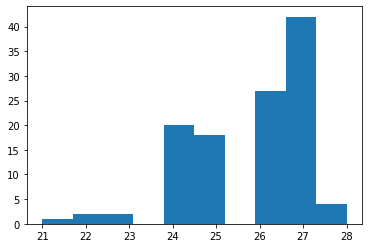

In [ ]:
#correlate this with successful loopings

In [251]:

outDirec= 'output/'
x='beta'
for num,prot in enumerate(eprn):
    nu.dump_npdb(prot,f'{outDirec}build{x}_{num}.pdb')

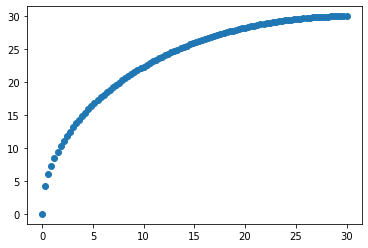

In [26]:
plt.scatter(circ_gp[:,0],circ_gp[:,2])

| 7 | 7 |   |   |   |   |   |   |   |   |   |   |
|---|---|---|---|---|---|---|---|---|---|---|---|
|   | 6 |   |   |   |   |   |   |   |   |   |   |
|   | 5 |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |
|   |   |   |   |   |   |   |   |   |   |   |   |